In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import xgboost as xgb
import seaborn as sns
import itertools
import optuna

In [2]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [3]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)
    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            #cross_term_name = f"{feature1}_divided_{feature2}"
            #df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [4]:
y = np.log1p(train['Calories'])

X = add_feats(train, numerical_features)

X.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,36,189,82,26,101,41.0,22.955684,15.21,6804,...,15498,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0
1,female,64,163,60,8,85,39.7,22.582709,6.76,10432,...,9780,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5
2,female,51,161,64,7,84,39.8,24.690405,7.29,8211,...,10304,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2
3,male,20,192,90,25,105,40.7,24.414062,12.96,3840,...,17280,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5
4,female,38,166,61,25,102,40.6,22.136740,12.25,6308,...,10126,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2


Use Optuna for hyperparameter selection.

In [4]:
y = np.log1p(train['Calories'])
X = add_feats(train, numerical_features)

def objective(trial):
    
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset. (not supported on GPU)
        # "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": 0.8,
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # use GPU
        'device': 'cuda',
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": trial.suggest_int("max_depth", 6, 12, step=2),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "eta": trial.suggest_float("eta", 0.005, 0.3, step=0.005),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }


        



    # Cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)
    
    scores = []

    # Perform cross-validation manually
    for train_idx, valid_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Create Dataset for validation to enable early stopping
        dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
        dtest = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

        # Initialize and train the model with the suggested hyperparameters
        # Use high boost rounds that will more than likely be stopped by early stopping rounds
        model = xgb.train(param, dtrain, num_boost_round=2000,
                          evals=[(dtrain, 'train'), (dtest, 'eval')], early_stopping_rounds=40, verbose_eval=False)
        
        # print("Stopped at iteration:", model.best_iteration)

        # evaluate using only the best trees
        predictions = model.predict(dtest, iteration_range=(0, model.best_iteration))
        
        # Calculate the score
        score = rmse(y_val, predictions)
        scores.append(score)
    

    # Calculate mean RMSE
    error = np.mean(scores)
    return error


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize", study_name='xgb_early_stop', storage="sqlite:///xgboost.db", load_if_exists=True)
    study.optimize(objective, n_trials=1000, timeout=32400)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-06-21 00:14:24,977] Using an existing study with name 'xgb_early_stop' instead of creating a new one.
[I 2025-06-21 00:14:49,200] Trial 9 finished with value: 0.061219332440238076 and parameters: {'lambda': 0.00011525058811261093, 'alpha': 0.004891218885390323, 'colsample_bytree': 0.8733338270030928, 'max_depth': 10, 'min_child_weight': 6, 'eta': 0.185, 'gamma': 0.002241366618090038, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 0.060233872664862236.
[I 2025-06-21 00:17:03,498] Trial 10 finished with value: 0.06077308600955677 and parameters: {'lambda': 3.065149536508135e-07, 'alpha': 4.25226289106054e-06, 'colsample_bytree': 0.9877868151049276, 'max_depth': 12, 'min_child_weight': 2, 'eta': 0.015, 'gamma': 4.910916560961253e-08, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 0.060233872664862236.
[I 2025-06-21 00:17:30,685] Trial 11 finished with value: 0.06086967711041103 and parameters: {'lambda': 1.57897212944105e-08, 'alpha': 0.9504682648140133, 'colsa

Number of finished trials:  397
Best trial:
  Value: 0.059627947228760136
  Params: 
    lambda: 3.3114171034258904e-07
    alpha: 0.38248641585385146
    colsample_bytree: 0.39042420143740825
    max_depth: 8
    min_child_weight: 5
    eta: 0.01
    gamma: 4.368583054801034e-05
    grow_policy: depthwise


In [10]:
optuna.delete_study(study_name='xgb_early_stop', storage="sqlite:///xgboost.db")

Stopped at iteration: 1371
Train prediction: 0.05479388810238144
Test prediction: 0.05957318757431063


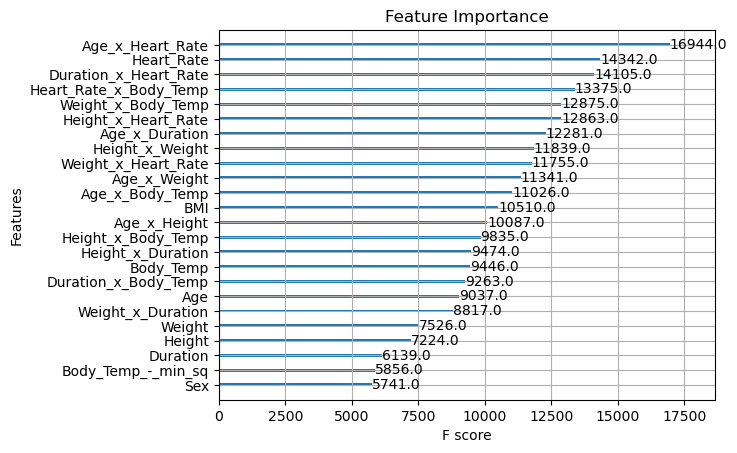

       id    Calories
0  750000   27.337826
1  750001  108.577797
2  750002   87.828552
3  750003  126.286606
4  750004   75.326347

count    250000.000000
mean         88.172272
std          62.258621
min           0.962711
25%          34.031118
50%          76.471676
75%         135.422386
max         293.119934
Name: Calories, dtype: float64


In [ ]:
# Kaggle score 0.05922 pub, 0.05751 priv, xgb_prediction_14.csv

# Best trial:
#   Value: 0.059627947228760136
#   Params: 
#     lambda: 3.3114171034258904e-07
#     alpha: 0.38248641585385146
#     colsample_bytree: 0.39042420143740825
#     max_depth: 8
#     min_child_weight: 5
#     eta: 0.01
#     gamma: 4.368583054801034e-05
#     grow_policy: depthwise


# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

# Define parameters
param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset. (not supported on GPU)
        # "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",
        # L2 regularization weight.
        "lambda": 3.3114171034258904e-07,
        # L1 regularization weight.
        "alpha": 0.38248641585385146,
        # sampling ratio for training data.
        "subsample": 0.8,
        # sampling according to each tree.
        "colsample_bytree": 0.39042420143740825,
        # use GPU
        'device': 'cuda',
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": 8,
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": 5,
        "eta": 0.01,
        # defines how selective algorithm is.
        "gamma": 4.368583054801034e-05,
        "grow_policy": "depthwise",
    }

# Initialize and train the model with the suggested hyperparameters
model = xgb.train(param, dtrain, num_boost_round=2000,
                        evals=[(dtrain, 'train'), (dtest, 'eval')], early_stopping_rounds=40, verbose_eval=False)
        
print("Stopped at iteration:", model.best_iteration)

# Make predictions
train_pred = model.predict(dtrain, iteration_range=(0, model.best_iteration))
test_pred = model.predict(dtest, iteration_range=(0, model.best_iteration))

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1
train_pred[train_pred > 320] = 300
test_pred[test_pred < 0] = 1
test_pred[test_pred > 320] = 300

print("Train prediction:", rmse(train_pred, y_train))
print("Test prediction:", rmse(test_pred, y_test))


# Get feature importance scores
# By default or in this example, the importance type is 'weight' - frequency that the feature is used
importance = model.get_score(importance_type='weight')

# Sort the importance dictionary by importance value
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)


# Plot feature importance using xgboost's built-in plot_importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()



# make the submission file!
pred = model.predict(xgb.DMatrix(add_feats(test, numerical_features), enable_categorical=True), iteration_range=(0, model.best_iteration))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("xgb_prediction_14.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [5]:
def objective(trial):
    (data, target) = (X, y)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=724)
    dtrain = xgb.DMatrix(train_x, label=train_y, enable_categorical=True)
    dvalid = xgb.DMatrix(valid_x, label=valid_y, enable_categorical=True)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset. (not supported on GPU)
        # "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # use GPU
        'device': 'cuda',
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 6, 10, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 0.3, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain, num_boost_round=150)
    preds = bst.predict(dvalid)
    
    error = rmse(valid_y, preds)
    return error


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, timeout=1800)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-05-31 15:42:42,044] A new study created in memory with name: no-name-d000071e-2c69-42e0-ae65-63d19722a26b
[I 2025-05-31 15:42:51,060] Trial 0 finished with value: 0.9558890739098859 and parameters: {'booster': 'gbtree', 'lambda': 4.742143725763643e-05, 'alpha': 0.047151924790220213, 'subsample': 0.8196654112462893, 'colsample_bytree': 0.8204615772491508, 'max_depth': 8, 'min_child_weight': 6, 'eta': 5.134603926932816e-05, 'gamma': 0.0005630412483859533, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9558890739098859.
[I 2025-05-31 15:43:10,297] Trial 1 finished with value: 0.9629416744099677 and parameters: {'booster': 'dart', 'lambda': 0.00014147103627012132, 'alpha': 0.0011431833319568397, 'subsample': 0.657349118400413, 'colsample_bytree': 0.21236141486239896, 'max_depth': 6, 'min_child_weight': 4, 'eta': 2.0534391389398783e-06, 'gamma': 2.1542260596410148e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.00018

Number of finished trials:  100
Best trial:
  Value: 0.0598712705324821
  Params: 
    booster: gbtree
    lambda: 0.30224791683022467
    alpha: 1.8452403038157162e-05
    subsample: 0.4538376169102877
    colsample_bytree: 0.6457901966246576
    max_depth: 10
    min_child_weight: 7
    eta: 0.05644198364888699
    gamma: 0.001145508468906142
    grow_policy: depthwise


In [6]:
max_depth = [10, 12]
learning_rate = [0.1, 0.05]
number_boosts = [100, 200]
subsamp = [0.75, 0.9, 1]

model_err = {}

for md, lr, nbr, ss in itertools.product(max_depth, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 

                
        # Define parameters
        params = {
            'max_depth': md,
            'eta': lr,                           # learning rate
            'objective': 'reg:squarederror',     # 
            'eval_metric': 'rmse',
            'subsample': ss,                     # subsample rate
            'device': 'cuda'
        }

        # Initialize and train the model
        model = xgb.train(params, dtrain, num_boost_round=nbr,
                          evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


        # Predict and evaluate the model
        y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
        y_pred[y_pred <= 0] = 10
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for max_depth={md}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"max_depth_{md}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=100, subsample=0.75: 0.06075632834839817
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=100, subsample=0.9: 0.06058865525795841
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=100, subsample=1: 0.060736706586758796
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=200, subsample=0.75: 0.06079437680245001
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=200, subsample=0.9: 0.06080382481313329
Mean Accuracy for max_depth=10, learn_rate=0.1, num_boost=200, subsample=1: 0.06077575259164873
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=100, subsample=0.75: 0.060876656310991595
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=100, subsample=0.9: 0.06072298557056843
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=100, subsample=1: 0.06103689377664482
Mean Accuracy for max_depth=10, learn_rate=0.05, num_boost=200, subsample=0.75: 0.06037333180586988
Mean Accuracy fo

In [7]:
max_depth = [8, 10]
learning_rate = [0.1, 0.05]
number_boosts = [150, 200, 250]
subsamp = [0.75, 0.9]

model_err = {}

for md, lr, nbr, ss in itertools.product(max_depth, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 

                
        # Define parameters
        params = {
            'max_depth': md,
            'eta': lr,                           # learning rate
            'objective': 'reg:squarederror',     # 
            'eval_metric': 'rmse',
            'subsample': ss,                     # subsample rate
            'device': 'cuda'
        }

        # Initialize and train the model
        model = xgb.train(params, dtrain, num_boost_round=nbr,
                          evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


        # Predict and evaluate the model
        y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
        y_pred[y_pred <= 0] = 10
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for max_depth={md}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"max_depth_{md}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=150, subsample=0.75: 0.06056078640211857
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=150, subsample=0.9: 0.06061870518507144
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=200, subsample=0.75: 0.06070156832074709
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=200, subsample=0.9: 0.06071038543243716
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=250, subsample=0.75: 0.06071848041450817
Mean Accuracy for max_depth=8, learn_rate=0.1, num_boost=250, subsample=0.9: 0.06059276409682783
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=150, subsample=0.75: 0.06024944336235401
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=150, subsample=0.9: 0.06050437915784966
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=200, subsample=0.75: 0.06035656913977204
Mean Accuracy for max_depth=8, learn_rate=0.05, num_boost=200, subsample=0.9: 0.060312404960457845
Mean Accuracy for ma

In [ ]:
max_depth = [6, 8]
learning_rate = [0.1, 0.05]
number_boosts = [125, 150, 175]
subsamp = [0.75, 0.9]

model_err = {}

for md, lr, nbr, ss in itertools.product(max_depth, learning_rate, number_boosts, subsamp):
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True)

    # Initialize a list to collect accuracy scores
    scores = []

    # Iterate over each fold
    for train_index, test_index in kf.split(X):

        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True) 

                
        # Define parameters
        params = {
            'max_depth': md,
            'eta': lr,                           # learning rate
            'objective': 'reg:squarederror',     # 
            'eval_metric': 'rmse',
            'subsample': ss,                     # subsample rate
            'device': 'cuda'
        }

        # Initialize and train the model
        model = xgb.train(params, dtrain, num_boost_round=nbr,
                          evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


        # Predict and evaluate the model
        y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
        y_pred[y_pred <= 0] = 1
        score = rmse(y_test, y_pred)
        scores.append(score)

            
    # Output the mean accuracy over all folds
    print(f"Mean Accuracy for max_depth={md}, learn_rate={lr}, num_boost={nbr}, subsample={ss}: {np.mean(scores)}")

    model_err[f"max_depth_{md}_learn_rate_{lr}_num_boost_{nbr}_subsample_{ss}"] = np.mean(scores)

# Find the key with the minimum value
min_key = min(model_err, key=model_err.get)

# Retrieve the minimum value
min_value = model_err[min_key]

# Print the result
print(f"The key with the minimum value is '{min_key}' with a value of {min_value}.")

Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=125, subsample=0.75: 0.06126157571950615
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=125, subsample=0.9: 0.061212125663776484
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=150, subsample=0.75: 0.06105484276171047
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=150, subsample=0.9: 0.06117718433591949
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=175, subsample=0.75: 0.06105633910305232
Mean Accuracy for max_depth=6, learn_rate=0.1, num_boost=175, subsample=0.9: 0.060972824860646715
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=125, subsample=0.75: 0.06171521158051221
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=125, subsample=0.9: 0.06177706618274492
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=150, subsample=0.75: 0.06158580128704151
Mean Accuracy for max_depth=6, learn_rate=0.05, num_boost=150, subsample=0.9: 0.061332011954011036
Mean Accuracy for 

In [20]:
# Kaggle score 0.05856, xgb_prediction_11.csv, max depth 8, learning rate 0.05, early_stopping_rounds 25, subsample 0.75

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

# Define parameters
params = {
            'max_depth': 8,
            'eta': 0.05,                         # learning rate
            'objective': 'reg:squarederror',     
            'eval_metric': 'rmse',
            'subsample': 0.75,                   # subsample rate
            'device': 'cuda'
         }

# Initialize and train the model
model = xgb.train(params, dtrain, num_boost_round=175,
                     evals=[(dtrain, 'train'), (xgb.DMatrix(X_test, label=y_test, enable_categorical=True), 'eval')], early_stopping_rounds=25, verbose_eval=False)


# Make predictions
y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
y_pred[y_pred <= 0] = 1
print(rmse(y_test, y_pred))


# Get feature importance scores
# By default or in this example, the importance type is 'weight' - frequency that the feature is used
importance = model.get_score(importance_type='weight')

# Sort the importance dictionary by importance value
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)


# Plot feature importance using xgboost's built-in plot_importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

NameError: name 'dtrain' is not defined

Test prediction: 0.05971559908392127
Train prediction: 0.05408389335277298


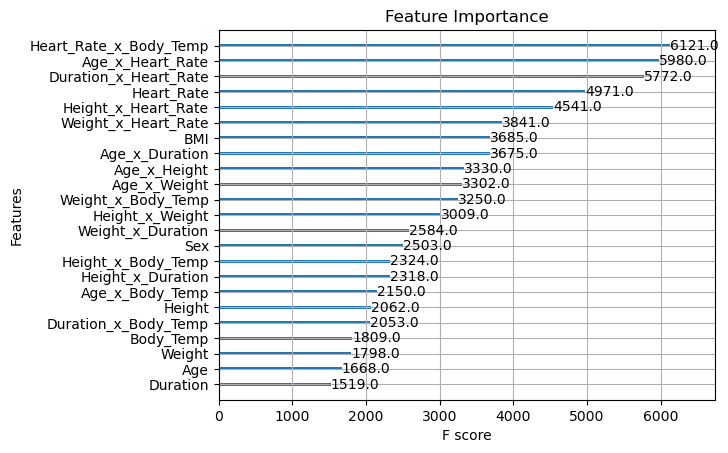

In [ ]:
# Kaggle score 0.05811, xgb_prediction_13.csv

# Best trial:
#   Value: 0.0598712705324821
#   Params: 
#     booster: gbtree
#     lambda: 0.30224791683022467
#     alpha: 1.8452403038157162e-05
#     subsample: 0.4538376169102877
#     colsample_bytree: 0.6457901966246576
#     max_depth: 10
#     min_child_weight: 7
#     eta: 0.05644198364888699
#     gamma: 0.001145508468906142
#     grow_policy: depthwise

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

# Define parameters
params = {
            'max_depth': 10,
            'eta': 0.05644198364888699,
            'objective': 'reg:squarederror',     
            # 'eval_metric': 'rmse',
            'subsample': 0.4538376169102877,
            'alpha': 1.8452403038157162e-05,
            'lambda': 0.30224791683022467,
            'colsample_bytree': 0.6457901966246576,
            'min_child_weight': 7,
            'gamma': 0.001145508468906142,
            'grow_policy': 'depthwise',
            'device': 'cuda'
         }

# Initialize and train the model
model = xgb.train(params, dtrain, num_boost_round=150)


# Make predictions
y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
y_pred[y_pred <= 0] = 1
print("Test prediction:", rmse(y_test, y_pred))

# Make predictions
train_pred = model.predict(xgb.DMatrix(X_train, enable_categorical=True))

# Ensure non-negative predictions (important for RMSLE)
train_pred[train_pred < 0] = 1

print("Train prediction:", rmse(train_pred, y_train))


# Get feature importance scores
# By default or in this example, the importance type is 'weight' - frequency that the feature is used
importance = model.get_score(importance_type='weight')

# Sort the importance dictionary by importance value
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)


# Plot feature importance using xgboost's built-in plot_importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

0.060450133356219314


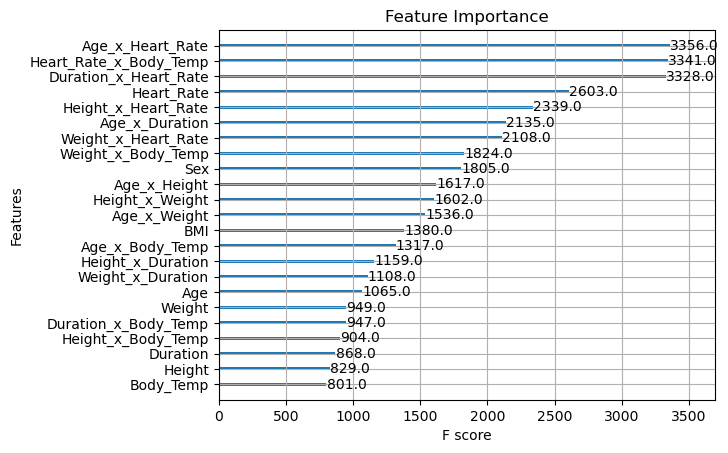

In [ ]:
# Kaggle score 0.05805, xgb_prediction_12.csv

# Best trial:
#   Value: 0.060084735018912865
#   Params: 
#     booster: gbtree
#     lambda: 3.6062754056505466e-08
#     alpha: 0.07212700928098835
#     subsample: 0.6610920778601266
#     colsample_bytree: 0.6075785274224256
#     max_depth: 9
#     min_child_weight: 6
#     eta: 0.05895594299077258
#     gamma: 0.00016183016923380773
#     grow_policy: lossguide

num_indices = 600000

train_index = np.random.choice(X.index, size=num_indices, replace=False)
test_index = list(set(np.arange(len(X))) - set(train_index))


X_train, X_test = X.loc[train_index], X.loc[test_index]
y_train, y_test = y.loc[train_index], y.loc[test_index]

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)

# Define parameters
params = {
            'max_depth': 9,
            'eta': 0.05895594299077258,
            'objective': 'reg:squarederror',     
            # 'eval_metric': 'rmse',
            'subsample': 0.6610920778601266,
            'alpha': 0.07212700928098835,
            'lambda': 3.6062754056505466e-08,
            'colsample_bytree': 0.6075785274224256,
            'min_child_weight': 6,
            'gamma': 0.00016183016923380773,
            'grow_policy': 'lossguide',
            'device': 'cuda'
         }

# Initialize and train the model
model = xgb.train(params, dtrain, num_boost_round=100)


# Make predictions
y_pred = model.predict(xgb.DMatrix(X_test, enable_categorical=True))
y_pred[y_pred <= 0] = 1
print(rmse(y_test, y_pred))


# Get feature importance scores
# By default or in this example, the importance type is 'weight' - frequency that the feature is used
importance = model.get_score(importance_type='weight')

# Sort the importance dictionary by importance value
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)


# Plot feature importance using xgboost's built-in plot_importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

In [7]:
test_mod = add_feats(test, numerical_features)

test_mod.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Age_x_Height,Age_x_Weight,...,Height_x_Weight,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp
0,male,45,177,81,7,87,39.8,25.854639,7965,3645,...,14337,1239,15399,7044.6,567,7047,3223.8,609,278.6,3462.6
1,male,26,200,97,20,101,40.5,24.250000,5200,2522,...,19400,4000,20200,8100.0,1940,9797,3928.5,2020,810.0,4090.5
2,female,29,188,85,16,102,40.4,24.049344,5452,2465,...,15980,3008,19176,7595.2,1360,8670,3434.0,1632,646.4,4120.8
3,female,39,172,73,20,107,40.6,24.675500,6708,2847,...,12556,3440,18404,6983.2,1460,7811,2963.8,2140,812.0,4344.2
4,female,30,173,67,16,94,40.5,22.386314,5190,2010,...,11591,2768,16262,7006.5,1072,6298,2713.5,1504,648.0,3807.0


In [8]:
# make the submission file!

pred = model.predict(xgb.DMatrix(test_mod, enable_categorical=True))

submission = pd.DataFrame()

submission['id'] = np.arange(len(test_mod))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1

submission.to_csv("xgb_prediction_13.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

       id    Calories
0  750000   27.685347
1  750001  107.331184
2  750002   87.520058
3  750003  126.088043
4  750004   75.487640

count    250000.000000
mean         88.162407
std          62.244381
min           0.925361
25%          34.022293
50%          76.437664
75%         135.407883
max         303.931030
Name: Calories, dtype: float64
